# Created by Cmoon

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('shww1.csv',index_col=0,dtype=np.float32)
mean=raw_data.mean()
std=raw_data.std()

In [3]:
print(raw_data.shape)
print(mean)
print(std)
print(raw_data.iloc[0:4, :])

(2276, 1)
high    9.098818
dtype: float32
high    4.414738
dtype: float32
        high
time        
0.0   14.569
1.0   14.908
2.0   15.173
3.0   15.149


In [4]:
numeric_features = raw_data.dtypes[raw_data.dtypes != 'object'].index
raw_data[numeric_features] = raw_data[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有数据都意味着消失，因此我们可以将缺失值设置为0
raw_data[numeric_features] = raw_data[numeric_features].fillna(0)
print(raw_data.iloc[0:4, :])

          high
time          
0.0   1.239073
1.0   1.315861
2.0   1.375888
3.0   1.370451


In [5]:
n_train = int(0.7*len(raw_data))
step=60
train_set=raw_data[:n_train].values
test_set=raw_data[n_train:].values
print(train_set.shape)

(1594, 1)


In [6]:
train_features=[]
train_labels=[]
test_features=[]
for i in range(step,n_train):
    train_features.append(train_set[i-step:i,0])
    train_labels.append(train_set[i,0])
for i in range(step,len(raw_data)-n_train):
    test_features.append(test_set[i-step:i,0])
    
train_features=torch.tensor(np.array(train_features),dtype=torch.float32)
train_labels=torch.tensor(np.array(train_labels),dtype=torch.float32).view(-1,1)
test_features=torch.tensor(np.array(test_features),dtype=torch.float32)

In [7]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(60,60,4 ,batch_first=True)
        
        self.dense = nn.Linear(60,1)

    def forward(self, x):
        lstm_out,hidden= self.lstm(x.view(len(x), 1, -1))
        prediction = self.dense(lstm_out.view(len(x), -1))
        return prediction


In [8]:
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.gru = nn.GRU(60, 10, batch_first=True)
        self.dense = nn.Linear(10, 1)


    def forward(self, x):
        gru_out,hidden= self.gru(x.view(len(x), 1, -1))
        prediction = self.dense(gru_out.view(len(x), -1))
        return prediction

In [9]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net(type):
    if type=='lstm':
        net=LSTM()
        print('lstm')
    elif type=='gru':
        net=GRU()
        print('gru')
    else:
        net = nn.Sequential(
                       nn.Linear(in_features,60),
                       nn.ReLU(),
                       nn.Linear(60,10),
                       nn.ReLU(),
                       nn.Linear(10,1))
        print('bpnn')
    return net

In [10]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    #optimizer = torch.optim.SGD(net.parameters(),
                                 #lr = learning_rate,
                                 #weight_decay = weight_decay)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            #print(X.shape)
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        #print(log_rmse(net, train_features, train_labels))
        #train_ls.append(log_rmse(net, train_features, train_labels))
        train_ls.append(l)
        if test_labels is not None:
            #test_ls.append(log_rmse(net, test_features, test_labels))
            test_ls.append(loss(net(test_features),test_labels))
    return train_ls, test_ls

In [11]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [12]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size,module):
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net=get_net(module)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            best_net=net
            best_ls=valid_ls[-1].clone().detach()
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='mse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
            
        print(f'fold {i + 1}, train mse {float(train_ls[-1]):f}, '
              f'valid mse {float(valid_ls[-1]):f}')
        if valid_ls[-1] < best_ls:
            best_net=net
            best_ls=valid_ls[-1].clone().detach()
        print(best_ls)
         
    return train_l_sum / k, valid_l_sum / k,best_net

lstm
fold 1, train mse 0.000370, valid mse 0.015599
tensor(0.0156)
lstm
fold 2, train mse 0.002418, valid mse 0.037252
tensor(0.0156)
lstm
fold 3, train mse 0.001549, valid mse 0.001605
tensor(0.0016)
lstm
fold 4, train mse 0.000491, valid mse 0.001964
tensor(0.0016)
lstm
fold 5, train mse 0.000687, valid mse 0.004375
tensor(0.0016)
5-折验证: 平均训练mse: 0.0011030009482055902, 平均验证mse: 0.012159104458987713


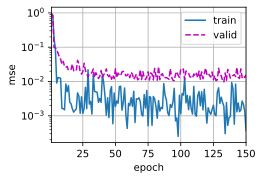

In [13]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 1e-3, 1e-3, 64
train_l1, valid_l1,net1 = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size,"lstm")
print(f'{k}-折验证: 平均训练mse: {train_l1}, '
      f'平均验证mse: {valid_l1}')

bpnn
fold 1, train mse 0.000676, valid mse 0.005000
tensor(0.0050)
bpnn
fold 2, train mse 0.000838, valid mse 0.004777
tensor(0.0048)
bpnn
fold 3, train mse 0.002324, valid mse 0.002807
tensor(0.0028)
bpnn
fold 4, train mse 0.002918, valid mse 0.001053
tensor(0.0011)
bpnn
fold 5, train mse 0.000142, valid mse 0.005046
tensor(0.0011)
5-折验证: 平均训练mse: 0.00137952936347574, 平均验证mse: 0.0037364214658737183


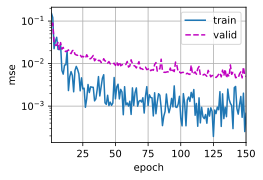

In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 1e-3, 1e-3, 64
train_l2, valid_l2,net2 = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size,'bpnn')
print(f'{k}-折验证: 平均训练mse: {train_l2}, '
      f'平均验证mse: {valid_l2}')

gru
fold 1, train mse 0.002078, valid mse 0.008991
tensor(0.0090)
gru
fold 2, train mse 0.001633, valid mse 0.030530
tensor(0.0090)
gru
fold 3, train mse 0.001012, valid mse 0.001398
tensor(0.0014)
gru
fold 4, train mse 0.001819, valid mse 0.000798
tensor(0.0008)
gru
fold 5, train mse 0.000278, valid mse 0.002162
tensor(0.0008)
5-折验证: 平均训练log rmse: 0.001363823190331459, 平均验证log rmse: 0.008775507099926472


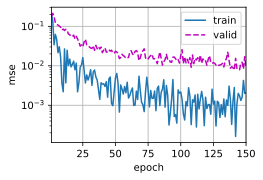

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 1e-3, 1e-3, 64
train_l3, valid_l3,net3 = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size,"gru")
print(f'{k}-折验证: 平均训练log rmse: {train_l3}, '
      f'平均验证log rmse: {valid_l3}')

In [16]:
predict1=[]
for x in test_features:
    predict1.append(net1(x.view(1,60))[0].detach().numpy())
#print(predict[0][0])
predict1=np.array(list(map(lambda x:(x * std) + mean,predict1)))
truth=np.array(list(map(lambda x:(x * std) + mean,test_set[60:])))

In [17]:
predict2=[]
for x in test_features:
    predict2.append(net2(x).detach().numpy())
#print(predict[0][0])
predict2=np.array(list(map(lambda x:(x * std) + mean,predict2)))

In [18]:
predict3=[]
for x in test_features:
    predict3.append(net3(x.view(1,60))[0].detach().numpy())
#print(predict[0][0])
predict3=np.array(list(map(lambda x:(x * std) + mean,predict3)))

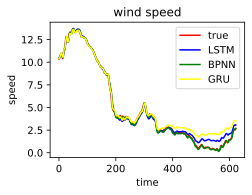

In [19]:
plt.plot(truth,color='red',label='true')
plt.plot(predict1,color='blue',label='LSTM')
plt.plot(predict2,color='green',label='BPNN')
plt.plot(predict3,color='yellow',label='GRU')
plt.title('wind speed')
plt.xlabel('time')
plt.ylabel('speed')
plt.legend()
plt.show()